In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import os
import torch.optim as optim

In [2]:
absolute_path = os.path.join(os.getcwd(), '/mnist')

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = MNIST(os.getcwd(), transform=transform, download=True)
test_dataset  = MNIST(os.getcwd(), transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

one_image_loader = DataLoader(train_dataset, batch_size=1, shuffle=True) # For visualising

In [4]:
def plot_image(tensor):

    if tensor.shape[0] == 1:
        tensor = tensor.squeeze(0)

    image = tensor.numpy()


    plt.imshow(image, cmap='gray' if tensor.ndim == 2 else None)
    plt.axis('off')
    plt.show()

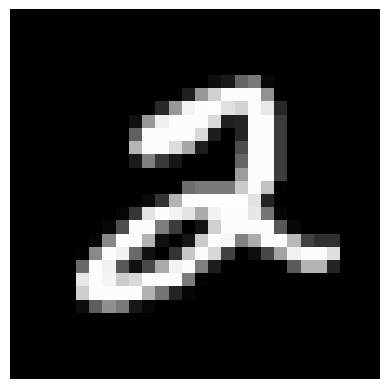

In [5]:
plot_image(train_dataset[5][0])

# Gaussian-Gaussian Autoencoder:

In [6]:
class GaussianAutoEncodingVariationalBayes(nn.Module):
    def __init__(self, input_dim, hidden_layers, inter_dim = 256, classification = False):
        super(GaussianAutoEncodingVariationalBayes, self).__init__()

        self.input_dim = input_dim
        self.hidden_layers = hidden_layers
        self.inter_dim = inter_dim

        # Appendix C.2, switch-out Z with X as described ============================
        self.encoder_mlp = nn.Sequential(
            nn.Linear(self.input_dim, inter_dim), # Here are the weights W_3 that make up phi
            nn.Tanh(),
        )

        self.latent_u_prediction_head = nn.Linear(inter_dim, hidden_layers) # Here are the weights W_4 that make up phi
        self.latent_variance_prediction_head = nn.Linear(inter_dim, hidden_layers) # Here are the weights W_5 that make up phi
        # ===========================================================================


        # Appendix C.2, implemented exactly in this way ---------------------------------
        self.decoder_mlp = nn.Sequential(
            nn.Linear(hidden_layers, inter_dim), # Here are the weights W_3 that make up theta
            nn.Tanh()
        )

        if classification:
            self.output_u_prediction_head = nn.Sequential(
            nn.Linear(inter_dim, input_dim), # Here are the weights W_4 that make up theta
            nn.Sigmoid() # Page 6 last sentence explains this part
            )
        else:
            nn.Linear(inter_dim,input_dim) # Here are the weights W_4 that make up theta

        self.output_variance_prediction_head = nn.Linear(inter_dim, input_dim) # Here are the weights W_5 that make up theta
        # ---------------------------------------------------------------------------------

    def encoder_forward(self, X):
        h = self.encoder_mlp(X)
        latent_u = self.latent_u_prediction_head(h)
        latent_logvariance = self.latent_variance_prediction_head(h)

        return latent_u, latent_logvariance # These are the estimates of parameters for q_phi(Z|X) ~ N(latent_u, latent_variance)

    def decoder_forward(self, Z):
        h = self.decoder_mlp(Z)
        output_u = self.output_u_prediction_head(h) # This is the main prediction of X_hat
        output_logvariance = self.output_variance_prediction_head(h) # Not needed to reconstruct, but gives us an estimate of the variance

        return output_u, output_logvariance # These are the estimates of parameters for p_theta(X|Z) ~ N(output_u, output_variance)

    def sample_from_prior(self):
        samples = torch.randn(self.hidden_layers) # This is a prior p(Z) ~ N(0,1)
        return samples

    def forward(self, X):
        latent_u, latent_logvariance = self.encoder_forward(X)
        sampled_error_e = self.sample_from_prior()

        Z = latent_u + torch.sqrt(torch.exp(latent_logvariance))*sampled_error_e # Latent variables Z

        X_hat, logvariance = self.decoder_forward(Z)

        return X_hat, logvariance, latent_u, latent_logvariance

# Gaussian-Bernoulli Autoencoder:

In [7]:
class BernoulliAutoEncodingVariationalBayes(nn.Module):
    def __init__(self, input_dim, hidden_layers, inter_dim = 256):
        super(BernoulliAutoEncodingVariationalBayes, self).__init__()

        self.input_dim = input_dim
        self.hidden_layers = hidden_layers
        self.inter_dim = inter_dim

        # Appendix C.2, switch-out Z with X as described ============================
        self.encoder_mlp = nn.Sequential(
            nn.Linear(self.input_dim, inter_dim), # Here are the weights W_3 that make up phi
            nn.Tanh()
        )

        self.latent_u_prediction_head = nn.Linear(inter_dim, hidden_layers) # Here are the weights W_4 that make up phi
        self.latent_variance_prediction_head = nn.Linear(inter_dim, hidden_layers) # Here are the weights W_5 that make up phi
        # ===========================================================================


        # Appendix C.1, implemented exactly in this way ---------------------------------
        self.decoder_mlp = nn.Sequential(
            nn.Linear(hidden_layers, inter_dim), # Here are the weights W_1 that make up theta
            nn.Tanh(),
            nn.Linear(inter_dim, input_dim), # Here are the weights W_2 that make up theta
            nn.Sigmoid()
        )
        # ---------------------------------------------------------------------------------


    def encoder_forward(self, X):
        h = self.encoder_mlp(X)
        latent_u = self.latent_u_prediction_head(h)
        latent_logvariance = self.latent_variance_prediction_head(h)

        return latent_u, latent_logvariance # These are the estimates of parameters for q_phi(Z|X) ~ N(latent_u, latent_variance)

    def decoder_forward(self, Z):
        return self.decoder_mlp(Z) # These are the estimates of parameters for p_theta(X|Z) ~ Bernoulli(Z)

    def sample_from_prior(self):
        samples = torch.randn(self.hidden_layers) # This is a prior p(Z) ~ N(0,1)
        return samples

    def forward(self, X):
        latent_u, latent_logvariance = self.encoder_forward(X)
        sampled_error_e = self.sample_from_prior()

        Z = latent_u + torch.sqrt(torch.exp(latent_logvariance))*sampled_error_e # Latent variables Z

        X_hat = self.decoder_forward(Z)

        return X_hat, latent_u, latent_logvariance

# Testing whether the VAE works:

In [53]:
BVAE = BernoulliAutoEncodingVariationalBayes(784, 2)

single_image, _ = next(iter(one_image_loader))
single_image = single_image.view(single_image.size(0),-1)

BVAE(single_image)

(tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1.

# Gaussian Reconstruction Loss:

In [10]:
def gaussian_log_likelihood(X, X_hat, logvar):
    reconstruction_loss = torch.sum(-0.5 * (torch.log(2 * torch.tensor(torch.pi)) + logvar + (X - X_hat) ** 2 / torch.exp(logvar)))
    return reconstruction_loss / X.size(0)  # Normalize by batch size

# Bernoulli Reconstruction Loss:

In [11]:
def bernoulli_log_likelihood(X, X_hat):
    X_hat = X_hat.clamp(min=0, max=1)
    X = X.clamp(min=0, max=1)
    bce_loss = torch.nn.functional.binary_cross_entropy(X_hat, X, reduction='sum')
    return bce_loss / X.size(0)

# Kullback Leiber Divergence:

In [12]:
def kullback_leiber_divergence(latent_u, latent_logvar):
    kl_div = -0.5 * torch.sum(1 + latent_logvar - latent_u.pow(2) - latent_logvar.exp())
    return kl_div

# Bernoulli Training

In [74]:
# The paper mentions initializing parameters with N(0, 0.01), but I've also provided a xavier initialization
def init_weights_normal(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=0.01)
        if m.bias is not None:
            nn.init.zeros_(m.bias)


def init_weights_xavier(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [78]:
BVAE = BernoulliAutoEncodingVariationalBayes(784, 2, 500)
BVAE.apply(init_weights_normal)
num_epochs = 30


optimizer = optim.Adam(BVAE.parameters(), lr=0.001)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)# Adjust learning rate as needed


for epoch in range(num_epochs):
    BVAE.train()
    train_loss = 0.0

    for batch_idx, (data, _) in enumerate(train_loader):
        # Assuming data is your input and is already properly scaled/preprocessed
        data = data.view(data.size(0), -1)  # Flatten the data if necessary
        optimizer.zero_grad()

        # Forward pass
        X_hat, latent_u, latent_logvar  = BVAE(data)

        # Compute losses
        kl_div_loss = kullback_leiber_divergence(latent_u, latent_logvar)
        recon_loss = bernoulli_log_likelihood(data, X_hat)
        loss = kl_div_loss + recon_loss

        if torch.isnan(loss):
            print("Stopping training due to NaN loss")
            break

        # Backward pass and optimize
        loss.backward()
        optimizer.step()


        train_loss += loss.item()

    # scheduler.step()
    # Compute average loss for this epoch
    average_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}')


Epoch [1/30], Loss: 2.7318
Epoch [2/30], Loss: 2.1058
Epoch [3/30], Loss: 2.0887
Epoch [4/30], Loss: 2.0804
Epoch [5/30], Loss: 2.0748
Epoch [6/30], Loss: 2.0712
Epoch [7/30], Loss: 2.0687
Epoch [8/30], Loss: 2.0665
Epoch [9/30], Loss: 2.0654
Epoch [10/30], Loss: 2.0643
Epoch [11/30], Loss: 2.0635
Epoch [12/30], Loss: 2.0631
Epoch [13/30], Loss: 2.0625
Epoch [14/30], Loss: 2.0624
Epoch [15/30], Loss: 2.0623
Epoch [16/30], Loss: 2.0622
Epoch [17/30], Loss: 2.0619
Epoch [18/30], Loss: 2.0620
Epoch [19/30], Loss: 2.0620
Epoch [20/30], Loss: 2.0617
Epoch [21/30], Loss: 2.0616
Epoch [22/30], Loss: 2.0616
Epoch [23/30], Loss: 2.0617
Epoch [24/30], Loss: 2.0616
Epoch [25/30], Loss: 2.0618
Epoch [26/30], Loss: 2.0615
Epoch [27/30], Loss: 2.0615
Epoch [28/30], Loss: 2.0615
Epoch [29/30], Loss: 2.0615
Epoch [30/30], Loss: 2.0615


# Plotting reconstructed image

In [79]:
def plot_images(original, reconstructed, height, width):

    if original.shape[0] == 1:
        original = original.squeeze(0)
    if len(original.shape) > 2:
        original = original.view(height, width)

    reconstructed = reconstructed.view(height, width)

    original_np = original.numpy()
    reconstructed_np = reconstructed.detach().numpy()

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(original_np, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(reconstructed_np, cmap='gray')
    axes[1].set_title('Reconstructed Image')
    axes[1].axis('off')

    plt.show()

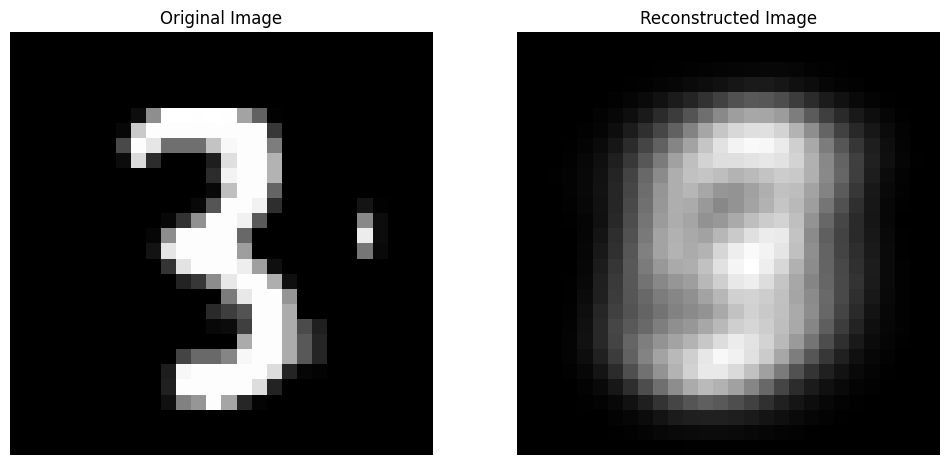

In [80]:
image = next(iter(one_image_loader))[0].squeeze(0)
height, width = image.shape[1], image.shape[2]
predict_format = image.view(image.size(0), -1)

image_hat, _, __ = BVAE(predict_format)

plot_images(image, image_hat, height, width)

In [81]:
def plot_latent_manifolds(model, height, width, num_points=20, scale = 1):


    z1 = np.linspace(-scale, scale, num_points)
    z2 = np.linspace(-scale, scale, num_points)
    z1, z2 = np.meshgrid(z1, z2)
    z_grid = np.vstack([z1.flatten(), z2.flatten()]).transpose()


    with torch.no_grad():
        model.eval()
        images = []
        for i in range(z_grid.shape[0]):
            z_sample = torch.tensor(z_grid[i]).float().unsqueeze(0)
            img = model.decoder_forward(z_sample).view(height, width).numpy()
            images.append(img)


    fig, ax = plt.subplots(num_points, num_points, figsize=(15, 15))
    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i], cmap='gray')
        axi.axis('off')

    plt.show()

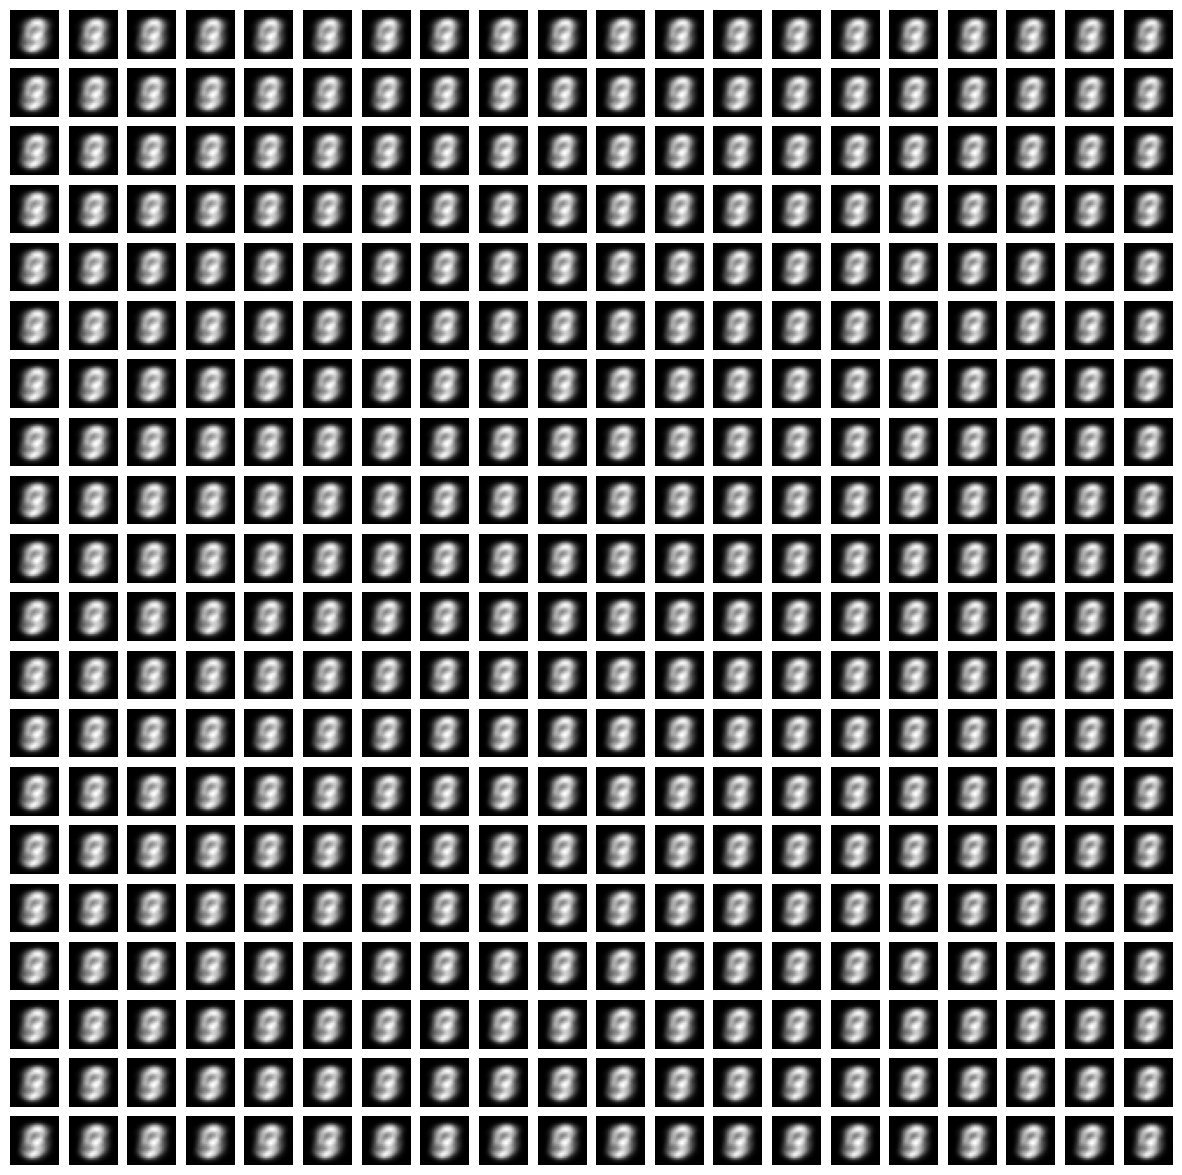

In [82]:
# BVAE.apply(init_weights_normal)
plot_latent_manifolds(BVAE, 28, 28, scale=2)

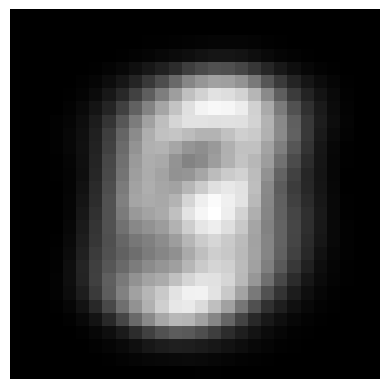

In [83]:
x_decoded = BVAE.decoder_forward(torch.tensor([1,0]).float())
digit = x_decoded.detach().cpu().reshape(28, 28)
plt.imshow(digit, cmap='gray')
plt.axis('off')
plt.show()

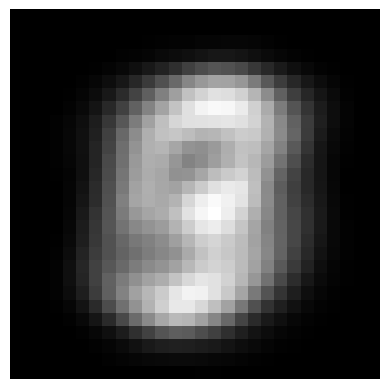

In [84]:
x_decoded = BVAE.decoder_forward(torch.tensor([0,1]).float())
digit = x_decoded.detach().cpu().reshape(28, 28)
plt.imshow(digit, cmap='gray')
plt.axis('off')
plt.show()